In [1]:
import gpflow
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def model(X):
    n, dim = X.shape
    return np.sum(np.sin(12*X) + 0.66*np.cos(25*X), axis=1)

In [3]:
np.random.seed(0)
dim = 1
model_budget = 12
n_pseudo = 10
X = np.linspace(0, 1, model_budget).reshape(-1, dim)
y = model(X).reshape(-1, 1)
Z = X[np.random.choice(range(model_budget), n_pseudo, replace=False)]

In [19]:
kernel = gpflow.kernels.Matern52(dim, lengthscales=1.)
basis = gpflow.mean_functions.Constant()
gp_gpflow = gpflow.gpr.GPR(X, y, kern=kernel, mean_function=basis)
gp_gpflow.likelihood.variance = 0.
gp_gpflow

Name,values,prior,constraint
name.kern.lengthscales,[ 1.],None,+ve
name.kern.variance,[ 1.],None,+ve
name.likelihood.variance,[ 0.],None,+ve
name.mean_function.c,[ 0.],None,(none)


In [20]:
optim = tf.train.GradientDescentOptimizer(1.)
optim = tf.train.AdagradOptimizer(0.5)
optim = 'L-BFGS-B'
#optim = 'SLSQP'
gp_gpflow.compile()
gp_gpflow.optimize(method=optim)

      fun: 14.443147513779422
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.90074354e-06,   5.61017956e-07,   5.69704194e-17,
        -4.24850909e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 25
   status: 0
  success: True
        x: array([ -2.79846617e+00,   9.78148494e-03,  -3.60436534e+01,
         6.39838400e-02])

In [21]:
gp_gpflow

Name,values,prior,constraint
name.kern.lengthscales,[ 0.05912182],None,+ve
name.kern.variance,[ 0.69805088],None,+ve
name.likelihood.variance,[ 1.00000000e-06],None,+ve
name.mean_function.c,[ 0.06398384],None,(none)


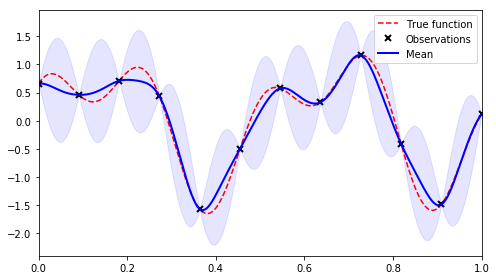

In [22]:
def plot_gpflow(ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4)) 
    x_plot = np.linspace(0., 1., 1000).reshape(-1, dim)
    y_plot = model(x_plot).reshape(-1, 1)
    y_pred, y_var = map(np.squeeze, gp_gpflow.predict_y(x_plot))
    ax.plot(x_plot, y_plot, 'r--', label="True function")
    ax.plot(X, y, 'kx', mew=2, label='Observations')
    ax.plot(x_plot, y_pred, '-b', lw=2, label='Mean')
    ax.fill_between(x_plot.squeeze(), y_pred - 2*np.sqrt(y_var) , y_pred + 2*np.sqrt(y_var), color='blue', alpha=0.1)
    ax.legend(loc=0)
    ax.set_xlim(0, 1)

fig, ax = plt.subplots(figsize=(7, 4))
plot_gpflow(ax)
fig.tight_layout()

In [23]:
import GPy
kernel = GPy.kern.Matern52(dim)
kernel.lengthscale = 0.1
gp_gpy = GPy.models.GPRegression(X, y, kernel=kernel)
gp_gpy.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   1.468615e+01   4.761227e-01 
    00s04  0010   1.452529e+01   5.456009e-02 
    00s06  0014   1.448392e+01   2.849762e-03 
    00s08  0018   1.446938e+01   1.000546e-03 
    00s12  0026   1.446618e+01   1.144206e-05 
    00s14  0030   1.446612e+01   1.375465e-08 
    00s18  0038   1.446621e+01   5.330691e-04 
    00s19  0040   1.446612e+01   6.581453e-10 
Runtime:     00s19
Optimization status: Converged



In [8]:
gp_gpy.optimize_restarts(num_restarts = 8, parallel=True);

Optimization restart 1/8, f = 14.466116163280017
Optimization restart 2/8, f = 14.748735988722004
Optimization restart 3/8, f = 14.748734877622415
Optimization restart 4/8, f = 14.466116563446684
Optimization restart 5/8, f = 14.466116198748557
Optimization restart 6/8, f = 14.74874395853012
Optimization restart 7/8, f = 14.748736012913586
Optimization restart 8/8, f = 14.466116240656746


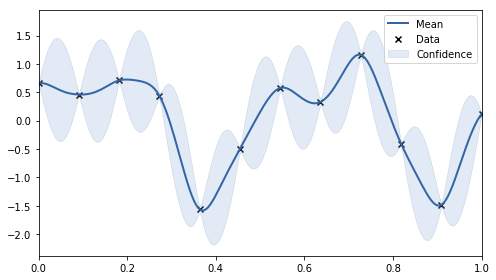

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))
gp_gpy.plot([0, 1], ax=ax)
fig.tight_layout()

### Sklearn

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
kernel = Matern(0.1)
gp_sklean = GaussianProcessRegressor(kernel=kernel)
gp_sklean.fit(X, y);

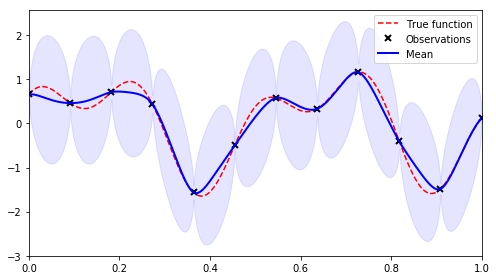

In [29]:
def plot_sklearn(ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4)) 
    x_plot = np.linspace(0., 1., 1000).reshape(-1, dim)
    y_plot = model(x_plot).reshape(-1, 1)
    y_pred, y_var = gp_sklean.predict(x_plot, return_std=True)
    y_pred = y_pred.squeeze()
    ax.plot(x_plot, y_plot, 'r--', label="True function")
    ax.plot(X, y, 'kx', mew=2, label='Observations')
    ax.plot(x_plot, y_pred, '-b', lw=2, label='Mean')
    ax.fill_between(x_plot.squeeze(), y_pred - 2*np.sqrt(y_var),
                    y_pred + 2*np.sqrt(y_var), color='blue', alpha=0.1)
    ax.legend(loc=0)
    ax.set_xlim(0, 1)

fig, ax = plt.subplots(figsize=(7, 4))
plot_sklearn(ax)
fig.tight_layout()

## Benchmark realizations

In [129]:
n_rea = 500
n_sample = 10000
X_rea = np.sort(np.random.rand(n_sample, dim).reshape(-1, dim), axis=0)

In [145]:
%%time
np.random.seed(0)
Y_rea_flow = gp_gpflow.predict_f_samples(X_rea, n_rea).squeeze()

Wall time: 40.9 s


In [146]:
%%time
np.random.seed(0)
Y_rea_gpy = gp_gpy.posterior_samples(X_rea, size=n_rea).T

Wall time: 5min 1s


In [133]:
%%time
np.random.seed(0)
Y_rea_sklearn = gp_sklean.sample_y(X_rea, n_rea)[:, 0, :].T

Wall time: 4min 45s


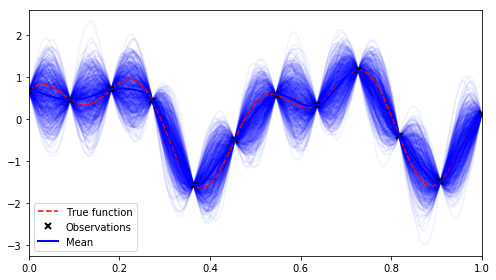

In [135]:
fig, ax = plt.subplots(figsize=(7, 4))
for y_rea in Y_rea_flow:
    ax.plot(X_rea, y_rea, 'b', alpha=0.05)
plot_gpflow(ax)
fig.tight_layout()

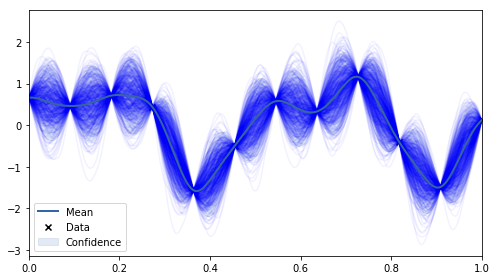

In [136]:
fig, ax = plt.subplots(figsize=(7, 4))
for y_rea in Y_rea_gpy:
    ax.plot(X_rea, y_rea, 'b-', alpha=0.05)
gp_gpy.plot([0, 1], ax=ax)
fig.tight_layout()

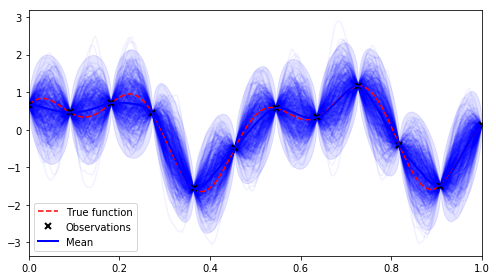

In [137]:
fig, ax = plt.subplots(figsize=(7, 4))
for y_rea in Y_rea_sklearn:
    ax.plot(X_rea, y_rea, 'b-', alpha=0.05)
plot_sklearn(ax)
fig.tight_layout()